En este archivo haremos un análisis exploratorio preliminar de los viajes de los "High Volume For-Hire Vehicle (HVFHV)" para el __segundo semestre__ del año __2022__. Esta categoría empezó a aplicarse en Febrero de 2019 en NYC a vehículos con más de 10000 viajes por día.

In [1]:
import modin.pandas as pd
from distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Inicializa un cliente Dask para la ejecución distribuida en múltiples núcleos
client = Client(memory_limit='8GB')

In [2]:
tlc_22_07 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-07.parquet")
tlc_22_08 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-08.parquet")
tlc_22_09 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-09.parquet")
tlc_22_10 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-10.parquet")
tlc_22_11 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-11.parquet")
tlc_22_12 = pd.read_parquet("../raw_data/fhvhv_tripdata_2022-12.parquet")

In [3]:
# Todos los dataframes del segundo semestre de 2022.
tlc_22_S2 = [tlc_22_07, tlc_22_08, tlc_22_09, tlc_22_10, tlc_22_11, tlc_22_12]

## Estructura general

In [4]:
tlc_22_07.dtypes

hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[ns]
on_scene_datetime       datetime64[ns]
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                     int64
DOLocationID                     int64
trip_miles                     float64
trip_time                        int64
base_passenger_fare            float64
tolls                          float64
bcf                            float64
sales_tax                      float64
congestion_surcharge           float64
airport_fee                    float64
tips                           float64
driver_pay                     float64
shared_request_flag             object
shared_match_flag               object
access_a_ride_flag              object
wav_request_flag                object
wav_match_flag                  object
dtype: object

Hay 24 columnas:
* 4 de tipo datetime.
* 9 de tipo float.
* 3 de tipo int.
* 8 de tipo object.

In [5]:
for df in tlc_22_S2:
    print(f"Filas: {df.shape[0]}")

Filas: 17464619
Filas: 17185687
Filas: 17793551
Filas: 19306090
Filas: 18085896
Filas: 19665847


In [6]:
tlc_22_07.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2022-07-01 00:36:26,2022-07-01 00:40:56,2022-07-01 00:41:13,2022-07-01 01:02:43,88,163,6.77,1290,5.70,2.75,0.0,11.19,47.65,N,N,,N,N
1,HV0003,B03404,B03404,2022-07-01 00:29:16,2022-07-01 00:32:07,2022-07-01 00:32:53,2022-07-01 01:10:19,131,265,22.39,2246,0.00,0.00,0.0,35.00,47.69,N,N,,N,N
2,HV0003,B03404,B03404,2022-06-30 23:54:05,2022-07-01 00:00:12,2022-07-01 00:00:38,2022-07-01 00:16:45,211,141,4.61,967,2.29,2.75,0.0,0.00,18.21,N,N,,N,N
3,HV0003,B03404,B03404,2022-07-01 00:18:22,2022-07-01 00:19:04,2022-07-01 00:21:05,2022-07-01 00:47:29,141,256,8.21,1584,3.36,2.75,0.0,0.00,25.07,N,N,,N,N
4,HV0003,B03404,B03404,2022-07-01 00:44:45,2022-07-01 00:49:04,2022-07-01 00:49:16,2022-07-01 00:55:47,80,148,2.20,391,0.83,2.75,0.0,0.00,7.58,N,N,,N,N


## Duplicados

Vamos a analizar la presencia de duplicados. Al haber tantas columnas, vamos a elegir un subset representativo. En caso de encontrar duplicados aplicaremos distintas estrategias.

In [7]:
#tlc_22_07.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

1

Este subset nos arroja 1 duplicado. Veamos si efectivamente se duplican todas las columnas.

In [4]:
#tlc_22_07[tlc_22_07.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                                       "PULocationID", "DOLocationID", "trip_miles"], 
#                                       keep=False)]

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
6492172,HV0003,B03404,B03404,2022-07-13 10:32:37,2022-07-13 10:34:08,2022-07-13 10:35:02,2022-07-13 11:31:02,10,164,14.68,3360,2.64,0.75,0.0,0.0,24.64,Y,Y,,N,N
6492173,HV0003,B03404,B03404,2022-07-13 10:32:22,2022-07-13 10:34:21,2022-07-13 10:35:02,2022-07-13 11:31:02,10,164,14.68,3360,2.43,0.75,0.0,0.0,24.64,Y,Y,,N,N


Vemos diferencia en algunas columnas, como request_datetime, por lo que no hay duplicados en Julio de 2022.

In [4]:
#tlc_22_08.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

39

Vemos 39 duplicados en este subset. Veamos si existen en el conjunto completo.

In [4]:
#tlc_22_08.duplicated().sum()

0

No hay duplicados en agosto de 2022.

In [4]:
#tlc_22_09.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

0

In [4]:
#tlc_22_10.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

0

In [4]:
#tlc_22_11.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

4

Vemos 4 duplicados en este subset. Veamos si existen en el conjunto completo.

In [4]:
#tlc_22_11.duplicated().sum()

0

No hay duplicados en noviembre de 2022.

In [4]:
#tlc_22_12.duplicated(subset=["pickup_datetime", "dropoff_datetime", 
#                             "PULocationID", "DOLocationID", "trip_miles"]).sum()

0

No hay duplicados en el segundo semestre de 2022.

## hvfhs_license_num

In [4]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.hvfhs_license_num.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [5]:
for df in tlc_22_S2:
    print(f"Los valores únicos por mes: "
          f"{df.hvfhs_license_num.unique()}")

Los valores únicos por mes: ['HV0003' 'HV0005']
Los valores únicos por mes: ['HV0003' 'HV0005']
Los valores únicos por mes: ['HV0003' 'HV0005']
Los valores únicos por mes: ['HV0003' 'HV0005']
Los valores únicos por mes: ['HV0003' 'HV0005']
Los valores únicos por mes: ['HV0005' 'HV0003']


In [6]:
for df in tlc_22_S2:
    print(df.hvfhs_license_num.value_counts(normalize=True), "\n")

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


hvfhs_license_num
HV0003    0.720068
HV0005    0.279932
Name: proportion, dtype: float64 

hvfhs_license_num
HV0003    0.72739
HV0005    0.27261
Name: proportion, dtype: float64 

hvfhs_license_num
HV0003    0.725112
HV0005    0.274888
Name: proportion, dtype: float64 

hvfhs_license_num
HV0003    0.730489
HV0005    0.269511
Name: proportion, dtype: float64 

hvfhs_license_num
HV0003    0.717023
HV0005    0.282977
Name: proportion, dtype: float64 

hvfhs_license_num
HV0003    0.712296
HV0005    0.287704
Name: proportion, dtype: float64 



Entre el 71-73% de las licencias corresponden a HV0003 (Uber) mientras que el 26-28% de las licencias restantes corresponden a HV0005 (Lyft).

## dispatching_base_num

In [7]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.dispatching_base_num.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [8]:
for df in tlc_22_S2:
    print(f"Los valores únicos por mes: "
          f"{sorted(df.dispatching_base_num.unique())}")

Los valores únicos por mes: ['B02395', 'B02512', 'B02617', 'B02764', 'B02765', 'B02835', 'B02864', 'B02869', 'B02870', 'B02871', 'B02872', 'B02876', 'B02877', 'B02878', 'B02880', 'B02882', 'B02887', 'B02888', 'B02889', 'B03404', 'B03406']
Los valores únicos por mes: ['B02395', 'B02512', 'B02617', 'B02682', 'B02764', 'B02765', 'B02835', 'B02864', 'B02866', 'B02869', 'B02870', 'B02871', 'B02872', 'B02876', 'B02877', 'B02879', 'B02880', 'B02882', 'B02883', 'B02887', 'B02888', 'B02889', 'B03404', 'B03406']
Los valores únicos por mes: ['B02512', 'B02764', 'B02765', 'B02835', 'B02864', 'B02866', 'B02869', 'B02870', 'B02871', 'B02872', 'B02876', 'B02877', 'B02878', 'B02880', 'B02882', 'B02887', 'B02888', 'B02889', 'B03404', 'B03406']
Los valores únicos por mes: ['B02512', 'B02764', 'B02765', 'B02835', 'B02864', 'B02866', 'B02869', 'B02870', 'B02871', 'B02872', 'B02876', 'B02877', 'B02880', 'B02882', 'B02887', 'B02888', 'B02889', 'B03404', 'B03406']
Los valores únicos por mes: ['B02512', 'B027

Cada base está asociada con una compañía distinta.

## originating_base_num

In [9]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.originating_base_num.isna().mean()}")

Promedio de nulos por mes: 0.2795983697096398
Promedio de nulos por mes: 0.2722521363271657
Promedio de nulos por mes: 0.27455379760903265
Promedio de nulos por mes: 0.26915429276461467
Promedio de nulos por mes: 0.2826010389532263
Promedio de nulos por mes: 0.2873301109278436


Hay un promedio de 26-28% de valores faltantes en esta columna.

In [10]:
for df in tlc_22_S2:
    print(f"Los valores únicos por mes: "
          f"{df.originating_base_num.unique()}")

Los valores únicos por mes: ['B03404' None 'B02764' 'B02887' 'B02395' 'B02871' 'B03406' 'B02889'
 'B02876' 'B02872' 'B02888' 'B02617' 'B02869' 'B02026' 'B02880' 'B02870'
 'B02765' 'B02835' 'B02882' 'B02864' 'B02512' 'B03153' 'B02877' 'B00887'
 'B02003' 'B02878']
Los valores únicos por mes: ['B03404' None 'B02887' 'B02872' 'B02764' 'B03406' 'B02395' 'B02880'
 'B02882' 'B02026' 'B02617' 'B02870' 'B02889' 'B02512' 'B02864' 'B02871'
 'B02765' 'B02835' 'B02869' 'B02876' 'B03153' 'B02888' 'B02877' 'B02866'
 'B02883' 'B02879' 'B02682' 'B00887' 'B02003']
Los valores únicos por mes: ['B03404' None 'B03406' 'B02887' 'B02872' 'B02864' 'B02764' 'B02889'
 'B02869' 'B02835' 'B02876' 'B02880' 'B02870' 'B02026' 'B03153' 'B02871'
 'B02888' 'B02882' 'B02512' 'B02765' 'B02866' 'B02877' 'B02878' 'B00887']
Los valores únicos por mes: ['B03404' None 'B02764' 'B02835' 'B02889' 'B02872' 'B03406' 'B02866'
 'B02869' 'B02887' 'B02870' 'B02871' 'B02765' 'B02876' 'B02888' 'B02512'
 'B02026' 'B02880' 'B03153' 'B028

## request_datetime

In [11]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.request_datetime.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [12]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.request_datetime.describe()}\n")

La descripción de cada mes es: count                         17464619
mean     2022-07-16 23:20:50.381675520
min                2022-06-30 21:50:00
25%         2022-07-09 09:44:13.500000
50%                2022-07-16 23:39:55
75%                2022-07-24 11:44:38
max                2022-08-01 00:10:00
Name: request_datetime, dtype: object

La descripción de cada mes es: count                         17185687
mean     2022-08-16 12:23:32.093091328
min                2022-07-31 22:59:00
25%         2022-08-08 16:16:06.500000
50%                2022-08-16 12:23:52
75%                2022-08-24 09:34:46
max                2022-09-01 00:10:00
Name: request_datetime, dtype: object

La descripción de cada mes es: count                         17793551
mean     2022-09-15 23:50:19.458807040
min                2022-08-31 22:42:17
25%                2022-09-08 18:20:29
50%                2022-09-15 22:36:25
75%                2022-09-23 12:37:45
max                2022-10-01 00:10:00
Name: requ

No se observan outliers. Los valores extremos se superponen entre meses en algunos casos.

## on_scene_datetime

In [13]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.on_scene_datetime.isna().mean()}")

Promedio de nulos por mes: 0.27959791164067194
Promedio de nulos por mes: 0.272249459681187
Promedio de nulos por mes: 0.2745121533076787
Promedio de nulos por mes: 0.26915429276461467
Promedio de nulos por mes: 0.28260109424492985
Promedio de nulos por mes: 0.2873301109278436


Hay un promedio de 26-28% de valores faltantes en esta columna.

In [14]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.on_scene_datetime.describe()}\n")

La descripción de cada mes es: count                         12581548
mean     2022-07-16 23:48:30.217252864
min                2022-06-30 23:05:55
25%      2022-07-09 11:19:16.750000128
50%                2022-07-17 00:24:45
75%      2022-07-24 11:08:07.249999872
max                2022-07-31 23:59:55
Name: on_scene_datetime, dtype: object

La descripción de cada mes es: count                         12506893
mean     2022-08-16 15:19:43.127905536
min                2022-07-31 22:48:02
25%                2022-08-08 20:00:14
50%                2022-08-16 17:01:21
75%                2022-08-24 12:30:56
max                2022-08-31 23:59:56
Name: on_scene_datetime, dtype: object

La descripción de cada mes es: count                         12909005
mean     2022-09-16 00:32:41.703098112
min                2022-08-31 23:20:00
25%                2022-09-08 18:46:32
50%                2022-09-15 23:01:55
75%                2022-09-23 13:42:59
max                2022-09-30 23:59:59
Name: on

No se observan outliers. Los valores extremos se superponen entre meses en algunos casos.

## pickup_datetime

In [15]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.pickup_datetime.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [16]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.pickup_datetime.describe()}\n")

La descripción de cada mes es: count                         17464619
mean     2022-07-16 23:25:45.415958016
min                2022-07-01 00:00:00
25%                2022-07-09 09:50:16
50%                2022-07-16 23:46:53
75%         2022-07-24 11:49:56.500000
max                2022-07-31 23:59:59
Name: pickup_datetime, dtype: object

La descripción de cada mes es: count                         17185687
mean     2022-08-16 12:28:20.186822144
min                2022-08-01 00:00:00
25%                2022-08-08 16:20:40
50%                2022-08-16 12:27:59
75%                2022-08-24 09:38:42
max                2022-08-31 23:59:59
Name: pickup_datetime, dtype: object

La descripción de cada mes es: count                         17793551
mean     2022-09-15 23:55:52.500426496
min                2022-09-01 00:00:00
25%                2022-09-08 18:27:19
50%                2022-09-15 22:43:28
75%                2022-09-23 12:43:47
max                2022-09-30 23:59:59
Name: pickup

No se observan outliers ni superposiciones entre los meses.

## dropoff_datetime

In [17]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.dropoff_datetime.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [18]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.dropoff_datetime.describe()}\n")

La descripción de cada mes es: count                         17464619
mean     2022-07-16 23:44:46.407636224
min                2022-07-01 00:03:44
25%                2022-07-09 10:05:50
50%                2022-07-17 00:05:40
75%                2022-07-24 12:06:53
max                2022-08-01 07:42:31
Name: dropoff_datetime, dtype: object

La descripción de cada mes es: count                         17185687
mean     2022-08-16 12:47:39.731855872
min                2022-08-01 00:03:26
25%                2022-08-08 16:41:34
50%                2022-08-16 12:48:11
75%                2022-08-24 09:58:00
max                2022-09-01 04:37:02
Name: dropoff_datetime, dtype: object

La descripción de cada mes es: count                         17793551
mean     2022-09-16 00:16:37.974391552
min                2022-09-01 00:02:52
25%                2022-09-08 18:53:38
50%                2022-09-15 23:04:08
75%                2022-09-23 13:07:17
max                2022-10-01 02:04:46
Name: drop

No se observan outliers. Los valores extremos se superponen entre meses en algunos casos.

## PULocationID

In [19]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.PULocationID.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [20]:
for df in tlc_22_S2:
    print(f"El número de zonas únicas de cada mes es: "
          f"{df.PULocationID.nunique()}")

El número de zonas únicas de cada mes es: 262
El número de zonas únicas de cada mes es: 261
El número de zonas únicas de cada mes es: 262
El número de zonas únicas de cada mes es: 261
El número de zonas únicas de cada mes es: 262
El número de zonas únicas de cada mes es: 262


Es la zona de taxi TLC donde inició el viaje. Hay 265 en total.

In [21]:
for df in tlc_22_S2:
    print(f"Mínimo: {df.PULocationID.min()}, Máximo {df.PULocationID.max()}")

Mínimo: 1, Máximo 265
Mínimo: 2, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 2, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265


No se observan outliers en esta columna.

## DOLocationID

In [22]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.DOLocationID.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [23]:
for df in tlc_22_S2:
    print(f"El número de zonas únicas de cada mes es: "
          f"{df.DOLocationID.nunique()}")

El número de zonas únicas de cada mes es: 262
El número de zonas únicas de cada mes es: 262
El número de zonas únicas de cada mes es: 261
El número de zonas únicas de cada mes es: 261
El número de zonas únicas de cada mes es: 261
El número de zonas únicas de cada mes es: 262


Es la zona de taxi TLC donde culminó el viaje. Hay 265 en total.

In [24]:
for df in tlc_22_S2:
    print(f"Mínimo: {df.DOLocationID.min()}, Máximo {df.DOLocationID.max()}")

Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265
Mínimo: 1, Máximo 265


No se observan outliers en esta columna.

## trip_miles

In [25]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.trip_miles.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [26]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.trip_miles.describe()}\n")

La descripción de cada mes es: count    1.746462e+07
mean     5.162379e+00
std      6.175706e+00
min      0.000000e+00
25%      1.670000e+00
50%      3.130000e+00
75%      6.420000e+00
max      6.142020e+02
Name: trip_miles, dtype: float64

La descripción de cada mes es: count    1.718569e+07
mean     5.203408e+00
std      6.190489e+00
min      0.000000e+00
25%      1.670000e+00
50%      3.150000e+00
75%      6.510000e+00
max      6.168100e+02
Name: trip_miles, dtype: float64

La descripción de cada mes es: count    1.779355e+07
mean     5.197236e+00
std      5.987033e+00
min      0.000000e+00
25%      1.651000e+00
50%      3.124000e+00
75%      6.510000e+00
max      5.033400e+02
Name: trip_miles, dtype: float64

La descripción de cada mes es: count    1.930609e+07
mean     5.059422e+00
std      5.911191e+00
min      0.000000e+00
25%      1.620000e+00
50%      3.040000e+00
75%      6.280000e+00
max      6.343200e+02
Name: trip_miles, dtype: float64

La descripción de cada mes es: count

Las distancias de 0 millas parecen ser errores. Veamos algunos ejemplos.

In [27]:
tlc_22_07[tlc_22_07.trip_miles == 0].head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
583,HV0003,B03404,B03404,2022-07-01 00:43:02,2022-07-01 00:45:20,2022-07-01 00:48:54,2022-07-01 00:55:19,48,48,0.0,385,1.05,2.75,0.0,0.0,8.47,N,N,,N,N
2495,HV0003,B03404,B03404,2022-06-30 23:57:35,2022-07-01 00:14:42,2022-07-01 00:14:42,2022-07-01 00:28:01,129,129,0.0,799,0.83,0.00,0.0,0.0,16.23,N,N,,N,N
2496,HV0003,B03404,B03404,2022-07-01 00:51:08,2022-07-01 00:58:12,2022-07-01 00:58:12,2022-07-01 01:23:46,129,129,0.0,1534,1.60,0.00,0.0,0.0,16.81,N,N,,N,N
6591,HV0003,B03404,B03404,2022-06-30 23:26:07,2022-07-01 00:04:15,2022-07-01 00:05:17,2022-07-01 00:09:08,114,114,0.0,231,1.07,0.75,0.0,0.0,7.14,Y,N,,N,N
7238,HV0003,B03404,B03404,2022-07-01 00:50:04,2022-07-01 00:55:20,2022-07-01 00:55:38,2022-07-01 00:59:37,148,148,0.0,239,0.70,2.75,0.0,0.0,8.09,N,N,,N,N


Vemos que en general son viajes cortos, dentro del mismo burough. Pueden ser errores o pueden ser viajes menores a 0,1 millas (160 m). Vamos a analizar outliers.

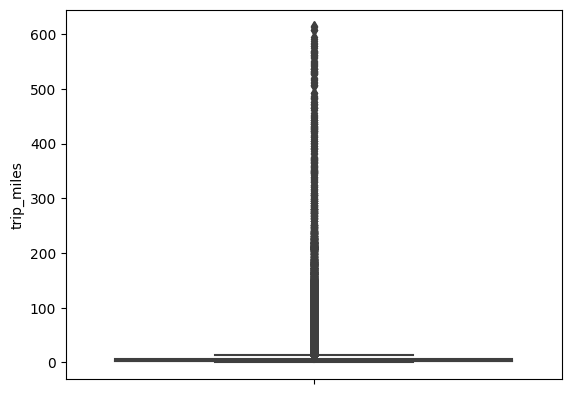

In [28]:
sns.boxplot(data = tlc_22_07, y="trip_miles");

Se observan numerosos outliers por este método. Quedará determinar si corresponde a errores o es debido a la dispersión de los datos. La superficie de NYC es de aproximadamente 468 millas cuadradas.

## trip_time

In [29]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.trip_time.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [30]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.trip_time.describe()}\n")

La descripción de cada mes es: count    1.746462e+07
mean     1.141127e+03
std      8.158417e+02
min      1.000000e+00
25%      5.980000e+02
50%      9.390000e+02
75%      1.449000e+03
max      4.324000e+04
Name: trip_time, dtype: float64

La descripción de cada mes es: count    1.718569e+07
mean     1.159654e+03
std      8.277056e+02
min      1.000000e+00
25%      6.010000e+02
50%      9.500000e+02
75%      1.478000e+03
max      4.936700e+04
Name: trip_time, dtype: float64

La descripción de cada mes es: count    1.779355e+07
mean     1.245576e+03
std      9.115649e+02
min      0.000000e+00
25%      6.260000e+02
50%      1.003000e+03
75%      1.588000e+03
max      4.323500e+04
Name: trip_time, dtype: float64

La descripción de cada mes es: count    1.930609e+07
mean     1.202721e+03
std      8.529928e+02
min      1.000000e+00
25%      6.170000e+02
50%      9.830000e+02
75%      1.541000e+03
max      4.443200e+04
Name: trip_time, dtype: float64

La descripción de cada mes es: count    

Tiempos de viaje de 0 segundos podrían ser errores. Veamos algunos casos.

In [33]:
tlc_22_12[tlc_22_12.trip_time == 0].head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
5027543,HV0003,B03404,B03404,2022-12-08 18:09:45,2022-12-08 18:14:13,2022-12-08 18:14:58,2022-12-08 18:14:58,158,158,0.0,0,0.64,2.75,0.0,0.0,11.12,N,N,,N,N
7761156,HV0003,B03404,B03404,2022-12-12 13:52:06,2022-12-12 13:55:08,2022-12-12 13:55:08,2022-12-12 13:55:08,209,209,0.0,0,0.64,2.75,0.0,0.0,0.00,N,N,,N,N


Hay solo 4 casos en el segundo semestre de 2022. Y el pickup_time coincide con el dropoff_time, por lo que es factible que se trate de errores. Hagamos un análisis preliminar de outliers.

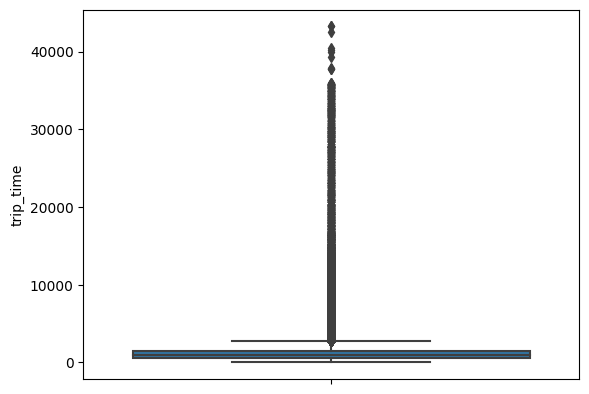

In [34]:
sns.boxplot(data = tlc_22_07, y="trip_time");

También se observan numerosos outliers que corresponderá estudiar.

## base_passenger_fare

In [35]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.base_passenger_fare.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [36]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.base_passenger_fare.describe()}\n")

La descripción de cada mes es: count    1.746462e+07
mean     2.353933e+01
std      1.979067e+01
min     -1.124000e+02
25%      1.139000e+01
50%      1.807000e+01
75%      2.882000e+01
max      2.672680e+03
Name: base_passenger_fare, dtype: float64

La descripción de cada mes es: count    1.718569e+07
mean     2.378705e+01
std      2.006733e+01
min     -1.702200e+02
25%      1.155000e+01
50%      1.815000e+01
75%      2.918000e+01
max      2.190780e+03
Name: base_passenger_fare, dtype: float64

La descripción de cada mes es: count    1.779355e+07
mean     2.536771e+01
std      2.125707e+01
min     -2.300500e+02
25%      1.207000e+01
50%      1.955000e+01
75%      3.130000e+01
max      2.230380e+03
Name: base_passenger_fare, dtype: float64

La descripción de cada mes es: count    1.930609e+07
mean     2.422593e+01
std      2.044771e+01
min     -3.332500e+02
25%      1.159000e+01
50%      1.864000e+01
75%      2.971000e+01
max      2.856690e+03
Name: base_passenger_fare, dtype: float64



Las tarifas negativas probablemente sean errores. Aquellas tarifas en el orden de 10^3, también es posible que sean errores, por alejarse del resto de los cuartilos. Hagamos un análisis preliminar de outliers.

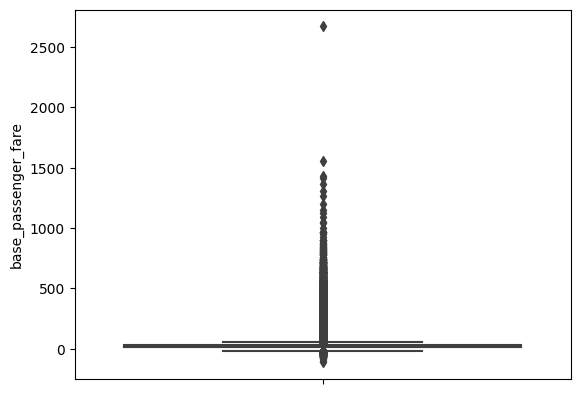

In [37]:
sns.boxplot(data = tlc_22_07, y="base_passenger_fare");

Se observan numerosos outliers por este método, por lo que corresponderá revisar si corresponden a errores en los datos o no.

## tolls

In [38]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.tolls.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [39]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.tolls.describe()}\n")

La descripción de cada mes es: count    1.746462e+07
mean     1.139453e+00
std      3.859080e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.340800e+02
Name: tolls, dtype: float64

La descripción de cada mes es: count    1.718569e+07
mean     1.163556e+00
std      3.913007e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.270000e+02
Name: tolls, dtype: float64

La descripción de cada mes es: count    1.779355e+07
mean     1.200301e+00
std      3.968928e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.885700e+02
Name: tolls, dtype: float64

La descripción de cada mes es: count    1.930609e+07
mean     1.149909e+00
std      3.911088e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.779200e+02
Name: tolls, dtype: float64

La descripción de cada mes es: count    1.808590e+07
mea

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

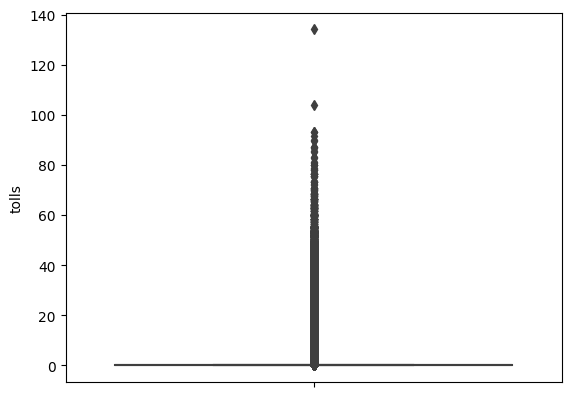

In [40]:
sns.boxplot(data = tlc_22_07, y="tolls");

Según este método, hay outliers por encima del bigote superior. Queda determinar si son errores o se deben a la distribución de los datos.

## bcf

In [41]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.bcf.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [42]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.bcf.describe()}\n")

La descripción de cada mes es: count    1.746462e+07
mean     5.322408e-01
std      6.402023e-01
min      0.000000e+00
25%      0.000000e+00
50%      3.800000e-01
75%      7.100000e-01
max      7.677000e+01
Name: bcf, dtype: float64

La descripción de cada mes es: count    1.718569e+07
mean     4.851225e-01
std      6.381132e-01
min      0.000000e+00
25%      0.000000e+00
50%      3.300000e-01
75%      6.700000e-01
max      5.908000e+01
Name: bcf, dtype: float64

La descripción de cada mes es: count    1.779355e+07
mean     8.038675e-01
std      7.118177e-01
min      0.000000e+00
25%      3.600000e-01
50%      5.900000e-01
75%      9.800000e-01
max      9.299000e+01
Name: bcf, dtype: float64

La descripción de cada mes es: count    1.930609e+07
mean     7.671580e-01
std      6.849278e-01
min      0.000000e+00
25%      3.500000e-01
50%      5.600000e-01
75%      9.300000e-01
max      8.709000e+01
Name: bcf, dtype: float64

La descripción de cada mes es: count    1.808590e+07
mean     7.

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

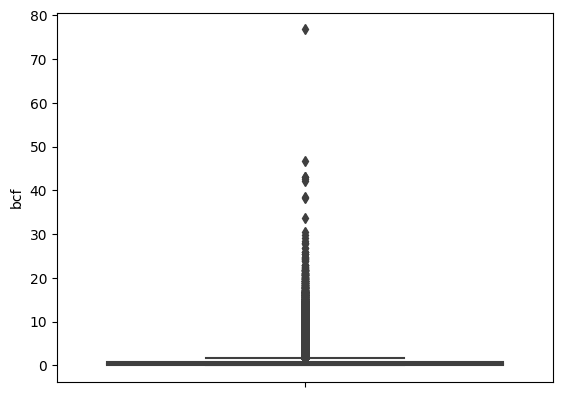

In [43]:
sns.boxplot(data = tlc_22_07, y="bcf");

Según este método, hay outliers por encima del bigote superior. Queda determinar si son errores o se deben a la distribución de los datos.

## sales_tax

In [44]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.sales_tax.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [45]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.sales_tax.describe()}\n")

La descripción de cada mes es: count    1.746462e+07
mean     1.952224e+00
std      1.614838e+00
min      0.000000e+00
25%      9.300000e-01
50%      1.500000e+00
75%      2.440000e+00
max      1.381900e+02
Name: sales_tax, dtype: float64

La descripción de cada mes es: count    1.718569e+07
mean     1.962041e+00
std      1.628181e+00
min      0.000000e+00
25%      9.400000e-01
50%      1.500000e+00
75%      2.450000e+00
max      1.911400e+02
Name: sales_tax, dtype: float64

La descripción de cada mes es: count    1.779355e+07
mean     2.151259e+00
std      1.772644e+00
min      0.000000e+00
25%      1.020000e+00
50%      1.660000e+00
75%      2.710000e+00
max      2.000300e+02
Name: sales_tax, dtype: float64

La descripción de cada mes es: count    1.930609e+07
mean     2.052574e+00
std      1.704185e+00
min      0.000000e+00
25%      9.700000e-01
50%      1.580000e+00
75%      2.570000e+00
max      2.576400e+02
Name: sales_tax, dtype: float64

La descripción de cada mes es: count    

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

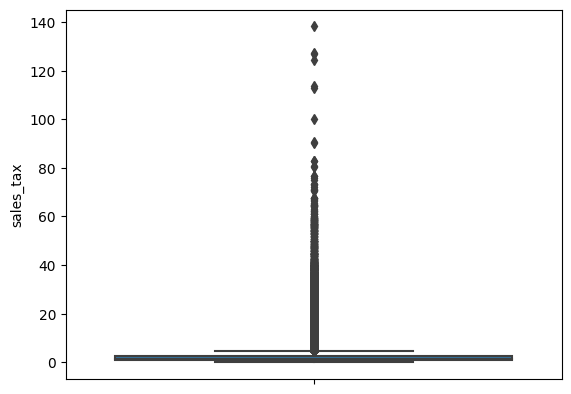

In [46]:
sns.boxplot(data = tlc_22_07, y="sales_tax");

Según este método, hay outliers por encima del bigote superior. Queda determinar si son errores o se deben a la distribución de los datos.

## congestion_surcharge

In [47]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.congestion_surcharge.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [48]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.congestion_surcharge.describe()}\n")

La descripción de cada mes es: count    1.746462e+07
mean     8.161456e-01
std      1.258017e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.750000e+00
max      8.250000e+00
Name: congestion_surcharge, dtype: float64

La descripción de cada mes es: count    1.718569e+07
mean     7.284148e-01
std      1.224356e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.750000e+00
max      1.100000e+01
Name: congestion_surcharge, dtype: float64

La descripción de cada mes es: count    1.779355e+07
mean     1.170692e+00
std      1.361590e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.750000e+00
max      8.250000e+00
Name: congestion_surcharge, dtype: float64

La descripción de cada mes es: count    1.930609e+07
mean     1.179565e+00
std      1.359013e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.750000e+00
max      1.100000e+01
Name: congestion_surcharge, dtype: float

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

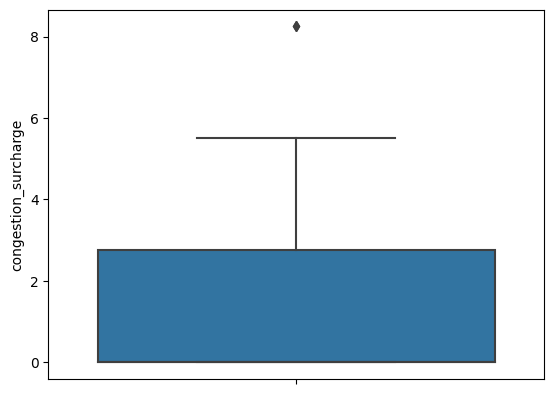

In [49]:
sns.boxplot(data = tlc_22_07, y="congestion_surcharge");

Se observan outliers por encima del bigote superior. No obstante, dado los valores absolutos, no parecen ser errores.

## airport_fee

In [50]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.airport_fee.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [51]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.airport_fee.describe()}\n")

La descripción de cada mes es: count    1.746462e+07
mean     1.517172e-01
std      6.011001e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.900000e+00
Name: airport_fee, dtype: float64

La descripción de cada mes es: count    1.718569e+07
mean     1.438025e-01
std      5.857851e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.900000e+00
Name: airport_fee, dtype: float64

La descripción de cada mes es: count    1.779355e+07
mean     2.215341e-01
std      7.140096e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.900000e+00
Name: airport_fee, dtype: float64

La descripción de cada mes es: count    1.930609e+07
mean     2.084287e-01
std      6.937080e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.900000e+00
Name: airport_fee, dtype: float64

La descripción de cada mes es: c

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

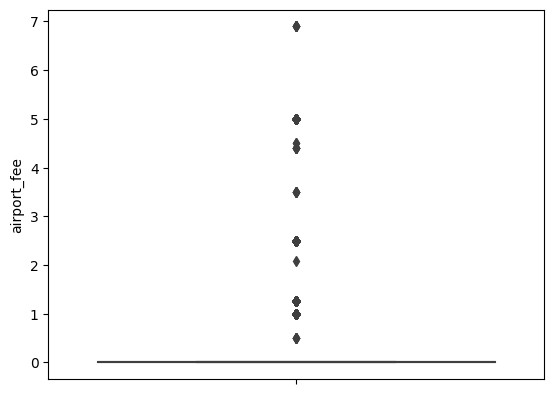

In [52]:
sns.boxplot(data = tlc_22_07, y="airport_fee");

Se observan outliers por encima del bigote superior. No obstante, dado los valores absolutos, no parecen ser errores.

## tips

In [53]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.tips.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [54]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.tips.describe()}\n")

La descripción de cada mes es: count    1.746462e+07
mean     1.051702e+00
std      2.969555e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.700000e+02
Name: tips, dtype: float64

La descripción de cada mes es: count    1.718569e+07
mean     1.048966e+00
std      2.976552e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.935500e+02
Name: tips, dtype: float64

La descripción de cada mes es: count    1.779355e+07
mean     1.177560e+00
std      3.259583e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.413800e+02
Name: tips, dtype: float64

La descripción de cada mes es: count    1.930609e+07
mean     1.147963e+00
std      3.140814e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.947900e+02
Name: tips, dtype: float64

La descripción de cada mes es: count    1.808590e+07
mean   

Los valores mínimos de 0 son factibles. Hagamos un análisis preliminar de outliers para ver los superiores.

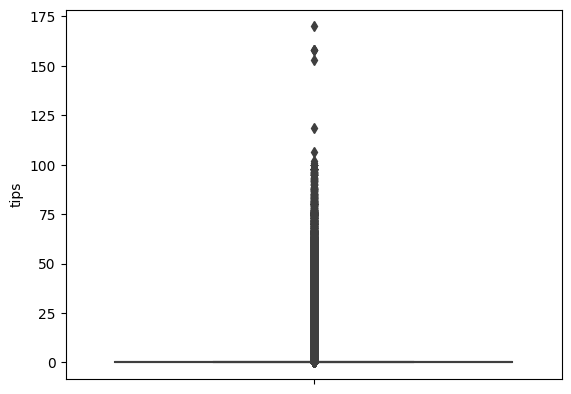

In [55]:
sns.boxplot(data = tlc_22_07, y="tips");

Según este método, hay outliers por encima del bigote superior. Queda determinar si son errores o se deben a la distribución de los datos.

## driver_pay

In [56]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.driver_pay.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [57]:
for df in tlc_22_S2:
    print(f"La descripción de cada mes es: "
          f"{df.driver_pay.describe()}\n")

La descripción de cada mes es: count    1.746462e+07
mean     1.859138e+01
std      1.560203e+01
min     -4.066400e+02
25%      8.980000e+00
50%      1.426000e+01
75%      2.299000e+01
max      1.924330e+03
Name: driver_pay, dtype: float64

La descripción de cada mes es: count    1.718569e+07
mean     1.840762e+01
std      1.567488e+01
min     -6.373000e+01
25%      8.680000e+00
50%      1.394000e+01
75%      2.282000e+01
max      1.359450e+03
Name: driver_pay, dtype: float64

La descripción de cada mes es: count    1.779355e+07
mean     2.027075e+01
std      1.640503e+01
min     -1.066300e+02
25%      9.620000e+00
50%      1.562000e+01
75%      2.537000e+01
max      1.347280e+03
Name: driver_pay, dtype: float64

La descripción de cada mes es: count    1.930609e+07
mean     1.952260e+01
std      1.573954e+01
min     -1.775000e+02
25%      9.420000e+00
50%      1.519000e+01
75%      2.446000e+01
max      2.021070e+03
Name: driver_pay, dtype: float64

La descripción de cada mes es: count

Los valores negativos es probable que sean errores. Haremos un análisis preliminar de outliers.

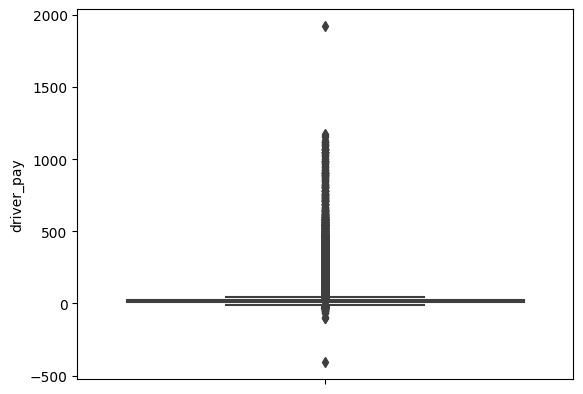

In [58]:
sns.boxplot(data = tlc_22_07, y="driver_pay");

Según este método, hay outliers por encima del bigote superior. Queda determinar si son errores o se deben a la distribución de los datos.

## shared_request_flag

In [59]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.shared_request_flag.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [60]:
for df in tlc_22_S2:
    print(f"Los valores únicos por mes: "
          f"{df.shared_request_flag.unique()}")

Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']


Las proporciones de usuarios que solicitaron compartir viajes fueron:

In [61]:
for df in tlc_22_S2:
    print(df.shared_request_flag.value_counts(normalize=True), "\n")

shared_request_flag
N    0.988484
Y    0.011516
Name: proportion, dtype: float64 

shared_request_flag
N    0.990388
Y    0.009612
Name: proportion, dtype: float64 

shared_request_flag
N    0.991567
Y    0.008433
Name: proportion, dtype: float64 

shared_request_flag
N    0.981947
Y    0.018053
Name: proportion, dtype: float64 

shared_request_flag
N    0.974996
Y    0.025004
Name: proportion, dtype: float64 

shared_request_flag
N    0.975004
Y    0.024996
Name: proportion, dtype: float64 



## shared_match_flag

In [62]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.shared_match_flag.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [63]:
for df in tlc_22_S2:
    print(f"Los valores únicos por mes: "
          f"{df.shared_match_flag.unique()}")

Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']


In [64]:
for df in tlc_22_S2:
    print(df.shared_match_flag.value_counts(normalize=True), "\n")

shared_match_flag
N    0.998301
Y    0.001699
Name: proportion, dtype: float64 

shared_match_flag
N    0.99896
Y    0.00104
Name: proportion, dtype: float64 

shared_match_flag
N    0.998869
Y    0.001131
Name: proportion, dtype: float64 

shared_match_flag
N    0.996118
Y    0.003882
Name: proportion, dtype: float64 

shared_match_flag
N    0.991416
Y    0.008584
Name: proportion, dtype: float64 

shared_match_flag
N    0.991157
Y    0.008843
Name: proportion, dtype: float64 



En todos los meses, menos del 1% de los pasajeros compartieron viajes.

## access_a_ride_flag

In [65]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.access_a_ride_flag.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [66]:
for df in tlc_22_S2:
    print(f"Los valores únicos por mes: "
          f"{df.access_a_ride_flag.unique()}")

Los valores únicos por mes: [' ' 'N']
Los valores únicos por mes: [' ' 'N']
Los valores únicos por mes: [' ' 'N']
Los valores únicos por mes: [' ' 'N']
Los valores únicos por mes: [' ' 'N']
Los valores únicos por mes: ['N' ' ']


Según el diccionario de datos, esta columna puede tomar los valores 'Y' o 'N'. La presencia de un string vacio puede hablar de problemas en la calidad de los datos.

## wav_request_flag

In [67]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.wav_request_flag.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [68]:
for df in tlc_22_S2:
    print(f"Los valores únicos por mes: "
          f"{df.wav_request_flag.unique()}")

Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']


In [69]:
for df in tlc_22_S2:
    print(df.wav_request_flag.value_counts(normalize=True), "\n")

wav_request_flag
N    0.99878
Y    0.00122
Name: proportion, dtype: float64 

wav_request_flag
N    0.998567
Y    0.001433
Name: proportion, dtype: float64 

wav_request_flag
N    0.998597
Y    0.001403
Name: proportion, dtype: float64 

wav_request_flag
N    0.998643
Y    0.001357
Name: proportion, dtype: float64 

wav_request_flag
N    0.998521
Y    0.001479
Name: proportion, dtype: float64 

wav_request_flag
N    0.998672
Y    0.001328
Name: proportion, dtype: float64 



En todos los meses, menos del 1% de los pasajeros solicitaron vehículos accesibles para sillas de ruedas.

## wav_match_flag

In [70]:
for df in tlc_22_S2:
    print(f"Promedio de nulos por mes: "
          f"{df.wav_match_flag.isna().mean()}")

Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0
Promedio de nulos por mes: 0.0


In [71]:
for df in tlc_22_S2:
    print(f"Los valores únicos por mes: "
          f"{df.wav_match_flag.unique()}")

Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']
Los valores únicos por mes: ['N' 'Y']


In [72]:
for df in tlc_22_S2:
    print(df.wav_match_flag.value_counts(normalize=True), "\n")

wav_match_flag
N    0.939248
Y    0.060752
Name: proportion, dtype: float64 

wav_match_flag
N    0.938725
Y    0.061275
Name: proportion, dtype: float64 

wav_match_flag
N    0.936399
Y    0.063601
Name: proportion, dtype: float64 

wav_match_flag
N    0.934461
Y    0.065539
Name: proportion, dtype: float64 

wav_match_flag
N    0.933531
Y    0.066469
Name: proportion, dtype: float64 

wav_match_flag
N    0.931977
Y    0.068023
Name: proportion, dtype: float64 



En todos los meses, aproximadamente el 6% de los viajes sucedieron en vehículos accesibles para sillas de ruedas.